<a href="https://colab.research.google.com/github/leeyangkyoo/Android-Bridge-App/blob/master/LSTM_%EB%8D%B0%EC%9D%B4%ED%83%80%20%EB%A1%9C%EB%94%A9%20%EB%B0%A9%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.12 LSTM 주가분석

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


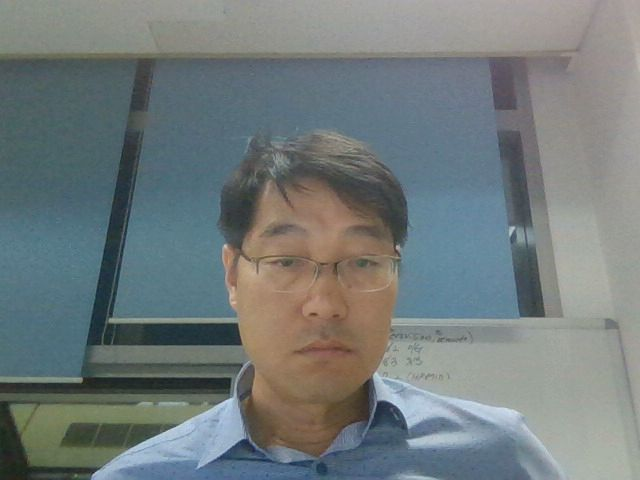

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
dataset = pd.read_csv("./sample01.csv", delimiter=",")

In [21]:
dataset = pd.read_csv("./lee0911_01.csv", delimiter=",")

In [13]:
dataset = pd.read_csv("./SEC005930.KS.csv", delimiter=",")

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      131072 non-null  float64
 1   Vol(FFT)  131072 non-null  float64
dtypes: float64(2)
memory usage: 2.0 MB


In [23]:
dataset.describe()

,Time,Vol(FFT)
count,131072.000000,131072.000000
mean,24999.809266,0.000141
std,14433.811790,0.013756
min,0.000000,0.000000
25%,12499.904632,0.000018
50%,24999.809265,0.000028
75%,37499.713897,0.000041
max,49999.618530,2.360404


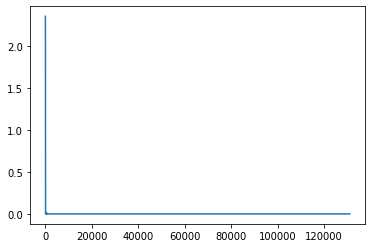

In [24]:
dataset['Vol(FFT)'].plot()

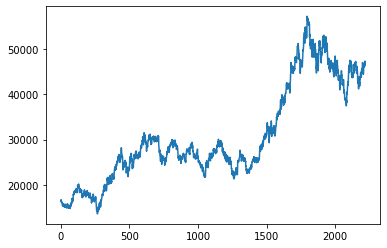

In [16]:
dataset['Close'].plot()

In [ ]:
dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df_price = dataset[["Close"]]

In [ ]:
scalar = MinMaxScaler()
df_price = scalar.fit_transform(df_price)

In [ ]:
price = df_price.tolist()
len(price)

2219

In [ ]:
price[1]

[0.06831728564878498]

In [ ]:
time_steps = 5
x = []
y = []

for i in range(len(price) - time_steps):
    x.append([price[i+j] for j in range(time_steps)])
    y.append(price[time_steps + i])


In [ ]:
x[0]

[[0.06327372764786798],
 [0.06831728564878498],
 [0.07198532783127004],
 [0.06740027510316371],
 [0.05960568546538286]]

In [ ]:
len(x)

2214

In [ ]:
y[0]

[0.05960568546538286]

In [ ]:
len(y)

2214

In [ ]:
x = np.asarray(x)
y = np.asarray(y)

In [ ]:
x[0]

array([[0.06327373],
       [0.06831729],
       [0.07198533],
       [0.06740028],
       [0.05960569]])

In [ ]:
x[1]

array([[0.06831729],
       [0.07198533],
       [0.06740028],
       [0.05960569],
       [0.05960569]])

In [ ]:
x[2]

In [ ]:
y[0]

In [ ]:
y[1]

In [ ]:
print(len(x))
print(len(y))

2214
2214


In [ ]:
train_test_split = 2000

x_train = x[:train_test_split, :]
y_train = y[:train_test_split]

x_test = x[train_test_split:, :]
y_test = y[train_test_split :]

In [ ]:
x_train.shape

(2000, 5, 1)

In [ ]:
x_test.shape

(214, 5, 1)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_train[0]

array([[0.06327373],
       [0.06831729],
       [0.07198533],
       [0.06740028],
       [0.05960569]])

In [ ]:
x_train.shape

(2000, 5, 1)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape=(None,1)),
  tf.keras.layers.Dropout(0.3),
  #tf.keras.layers.Dense(1, activation='linear')
  tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, epochs=250, batch_size=32,validation_data=(x_test, y_test), verbose=2, shuffle=False)

Epoch 1/250
63/63 - 1s - loss: 0.0084 - val_loss: 0.0093
Epoch 2/250
63/63 - 0s - loss: 0.0096 - val_loss: 0.0030
Epoch 3/250
63/63 - 0s - loss: 0.0052 - val_loss: 0.0020
Epoch 4/250
63/63 - 0s - loss: 0.0035 - val_loss: 7.3366e-04
Epoch 5/250
63/63 - 0s - loss: 0.0031 - val_loss: 7.4368e-04
Epoch 6/250
63/63 - 0s - loss: 0.0032 - val_loss: 5.8160e-04
Epoch 7/250
63/63 - 0s - loss: 0.0029 - val_loss: 6.1620e-04
Epoch 8/250
63/63 - 0s - loss: 0.0029 - val_loss: 0.0013
Epoch 9/250
63/63 - 0s - loss: 0.0035 - val_loss: 6.6961e-04
Epoch 10/250
63/63 - 0s - loss: 0.0041 - val_loss: 0.0027
Epoch 11/250
63/63 - 0s - loss: 0.0033 - val_loss: 0.0014
Epoch 12/250
63/63 - 0s - loss: 0.0026 - val_loss: 0.0020
Epoch 13/250
63/63 - 0s - loss: 0.0022 - val_loss: 6.9441e-04
Epoch 14/250
63/63 - 0s - loss: 0.0022 - val_loss: 9.7253e-04
Epoch 15/250
63/63 - 0s - loss: 0.0025 - val_loss: 8.2367e-04
Epoch 16/250
63/63 - 0s - loss: 0.0024 - val_loss: 0.0011
Epoch 17/250
63/63 - 0s - loss: 0.0028 - val_loss

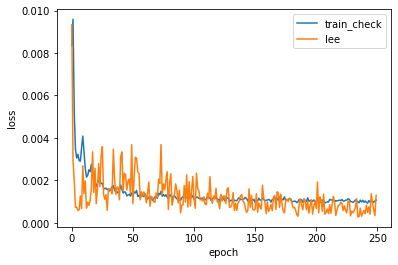

In [ ]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'], label='train_check')
plt.plot(hist.history['val_loss'], label='lee')
#plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend()
plt.show()

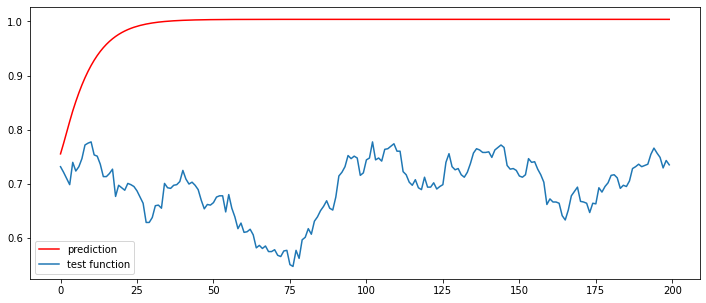

In [ ]:
look_ahead = 200
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

In [ ]:

# plt.figure(figsize=(10,10))
# plt.plot(price)

# split_pt = train_test_split + time_steps
# plt.plot(np.arange(window_size, split_pt, 1), train_predict, color='g')

# plt.plot(np.arange(split_pt, split_pt + len(test_predict), 1), test_predict, color='r')